In [1]:
import pandas as pd
from numpy import *
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter,ScalarFormatter, FuncFormatter
import matplotlib.ticker

## Import de dados

In [2]:
# Dados começam 01/01/2022
# Vacinação começa 19/01/2022
# fillna(0) substitui todos os valores sem input por 0
Dados= pd.read_csv ('../../dados_usados/Dados_novos_BAHIA.csv')
vacinados_dados = Dados['Vacinados'].fillna(0)
mortos_dados = Dados['Mortos'].fillna(0)
casos_dados = Dados['Casos acumulados']
datas = Dados["datetime"].fillna(0)

## Parametros

In [3]:
# Ultima revisão: 05/01/2023
k = 1/4
gamma_a = 1/3.5
gamma_s = 1/4
gamma_h = 0.18
gamma_u = 0.13
mi_u = 0.4
qsi = 0.53 
h = 0.06
h_v = 0.012
mi_h = 0.15
ome_h = 0.14
ome_u = 0.29
delta = 0.31
p = 0.2

# Parametros da vacina    
delta_av = 0.31
delta_sv = 0.31
phi_e = 0.7
k_v=1/3
p_v = 0.1
gamma_av = 1/3.5
gamma_sv = 1/4
gamma_vu=0.26
qsi_v = 0.99
eps=0.7 # eficacia da vacina
mi_vh=0.03
mi_vu=0.08
gamma_vh=0.36

## Recriando condições de simulação feitas em taxa de vacinação alterada e em vacina antecipada

### Taxa alterada

#### Vacinação sem adiantamento

In [4]:
vacinados_dados_aux =  copy(vacinados_dados)
# Diffs menores que 0 serão substituidos pela repetição do valor anterior, tornando todo valor igual ou maior que o anterior
for i in range(1,len(vacinados_dados_aux)):
    diff = vacinados_dados_aux[i] - vacinados_dados_aux[i-1]
    if diff < 0:
        vacinados_dados_aux[i-1] = vacinados_dados_aux[i]

novos_vacinados =  np.diff(vacinados_dados_aux)
novos_vacinados = novos_vacinados.tolist()

for i in range(150):
    novos_vacinados.insert(0, 0)

for i in range(150):
    novos_vacinados.pop()
print(len(novos_vacinados))

333


### Vacinação adiantada pro inicio do ano 

In [5]:
vacinados_dados_adiantados = vacinados_dados[19:]
vacinados_dados_adiantados = vacinados_dados_adiantados.tolist()
for item in range(19):
    vacinados_dados_adiantados.append(0)

vacinados_dados_aux =  copy(vacinados_dados_adiantados)
# Diffs menores que 0 serão substituidos pela repetição do valor anterior, tornando todo valor igual ou maior que o anterior
for i in range(1,len(vacinados_dados_aux)):
    diff = vacinados_dados_aux[i] - vacinados_dados_aux[i-1]
    if diff < 0:
        vacinados_dados_aux[i-1] = vacinados_dados_aux[i]

novos_vacinados_adiantados =  np.diff(vacinados_dados_aux)
novos_vacinados_adiantados = novos_vacinados_adiantados.tolist()
novos_vacinados_adiantados.insert(0, 0)

print(len(novos_vacinados_adiantados))

334


#### Vacinação adiantada pro inicio geral

In [6]:
vacinados_dados_adiantados_inicial = vacinados_dados[150:]
vacinados_dados_adiantados_inicial = vacinados_dados_adiantados_inicial.tolist()
print(vacinados_dados_adiantados_inicial[0])
for item in range(150):
    vacinados_dados_adiantados_inicial.append(0)

vacinados_dados_aux_inicial =  copy(vacinados_dados_adiantados_inicial)
# Diffs menores que 0 serão substituidos pela repetição do valor anterior, tornando todo valor igual ou maior que o anterior
for i in range(1,len(vacinados_dados_aux_inicial)):
    diff = vacinados_dados_aux_inicial[i] - vacinados_dados_aux_inicial[i-1]
    if diff < 0:
        vacinados_dados_aux_inicial[i-1] = vacinados_dados_aux_inicial[i]

novos_vacinados_adiantados_inicial =  np.diff(vacinados_dados_aux_inicial)
novos_vacinados_adiantados_inicial = novos_vacinados_adiantados_inicial.tolist()
novos_vacinados_adiantados_inicial.insert(0, 0)

print(len(novos_vacinados_adiantados_inicial))

3387794.0
334


### Condições iniciais normais

In [7]:
condicoes_iniciais = [
    0.8002151436282163 ,
    0.0023662791892471815,
    0,
    0,
    0,
    0.0015491725384642486,
    0.0004385474858925033,
    0,
    0,
    3.0058880370174367e-05,
    0.0,
    2.5542546092586197e-05,
    0.0,
    0.15650499264821266,
    0,
    9159/14873064,
    0.03581418879497971,
    0
]

#### Condições iniciais com vacinação adiantada

In [8]:
condicoes_iniciais2 = [
    0.8002151436282163 ,
    0.0023662791892471815,
    vacinados_dados_adiantados_inicial[0]/14873064,
    0,
    0,
    0.0015491725384642486,
    0.0004385474858925033,
    0,
    0,
    3.0058880370174367e-05,
    0.0,
    2.5542546092586197e-05,
    0.0,
    0.15650499264821266,
    0,
    9159/14873064,
    0.03581418879497971,
    0
]

## Gerando fator multiplicativo

In [9]:
vacinados_soma = sum(np.diff(vacinados_dados))
fator_multiplicacao = 14873064/vacinados_soma
fator_multiplicacao = math.fabs(1-fator_multiplicacao)
print(fator_multiplicacao)

0.39093790970791553


## Modelo

In [10]:
def SEIIHURD(y,t, args):

    beta0, beta1, beta2,beta3, t1, t2,t3, listau = args

    if t<t1:
        beta=beta0    
    elif (t>=t1):
        beta=beta1
    elif (t>=t2):
        beta=beta2
    elif t>=t3:
        beta=beta3

    beta_v = beta/2
    
    tau = listau[int(t)]

    N=14873064
    
    psi= 0.5  #Psif[int(t)]
    S=y[0]
    E=y[1]
    V=y[2]
    Sv=y[3]
    Ev=y[4]
    Ia=y[5]
    Is=y[6]
    Iav=y[7]
    Isv=y[8]
    H=y[9]
    Hv=y[10]
    U=y[11]
    Uv=y[12]
    R=y[13]
    Rv=y[14]
    D=y[15]
    Nw=y[16]
    NwV=y[17]

    dSdt = (-(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - tau/N
    dEdt = ((1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k*E
    dVdt = tau/N - phi_e*V - ((1-psi)*beta*V*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv))
    dSvdt =  phi_e*(1-eps)*V - ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) #- phi_e*eps*Sv
    dEvdt = ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k_v*Ev
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv   
    dHdt = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H   
    dHvdt = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vh*Hv    
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U
    dUvdt = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_vh*Hv - gamma_u*Uv
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H
    dRvdt = gamma_av*Iav + (1-h_v)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv) + phi_e*eps*V
    dDdt = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_u)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv)
    dNwdt = p*k*E + p_v*k_v*Ev
    dNwVdt = tau/N
        
    return [dSdt, dEdt, dVdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, 
            dRvdt, dDdt, dNwdt, dNwVdt]

## Função de adiantamento

In [11]:

def vacina_com_adiantamento_em(dias, diminuicao):
    vacinados_simulados = []

    if dias >= 0:
        vacinados_dados_adiantados_inicial = vacinados_dados[dias-diminuicao:]
        vacinados_dados_adiantados_inicial = vacinados_dados_adiantados_inicial.tolist()
        for item in range(dias-diminuicao):
            vacinados_dados_adiantados_inicial.append(0)

        vacinados_dados_aux_inicial =  copy(vacinados_dados_adiantados_inicial)
        # Diffs menores que 0 serão substituidos pela repetição do valor anterior, tornando todo valor igual ou maior que o anterior
        for i in range(1,len(vacinados_dados_aux_inicial)):
            diff = vacinados_dados_aux_inicial[i] - vacinados_dados_aux_inicial[i-1]
            if diff < 0:
                vacinados_dados_aux_inicial[i-1] = vacinados_dados_aux_inicial[i]

        novos_vacinados_adiantados_inicial =  np.diff(vacinados_dados_aux_inicial)
        novos_vacinados_adiantados_inicial = novos_vacinados_adiantados_inicial.tolist()
        vacinados_simulados = novos_vacinados_adiantados_inicial
        
    elif dias < 0:

        lista_de_zeros = np.zeros(abs(dias), dtype=int)   
        vacinados_atrasados_em_dias = np.append(lista_de_zeros, vacinados_dados)

        vacinados_atrasados_em_dias = vacinados_atrasados_em_dias[:len(vacinados_dados)]
        
        vacinados_dados_aux_inicial =  copy(vacinados_atrasados_em_dias)
        # Diffs menores que 0 serão substituidos pela repetição do valor anterior, tornando todo valor igual ou maior que o anterior
        for i in range(1,len(vacinados_dados_aux_inicial)):
            diff = vacinados_dados_aux_inicial[i] - vacinados_dados_aux_inicial[i-1]
            if diff < 0:
                vacinados_dados_aux_inicial[i-1] = vacinados_dados_aux_inicial[i]

        novos_vacinados_adiantados_inicial =  np.diff(vacinados_dados_aux_inicial)
        novos_vacinados_adiantados_inicial = novos_vacinados_adiantados_inicial.tolist()
        vacinados_simulados = novos_vacinados_adiantados_inicial  
          
    return np.array(vacinados_simulados)

### Função de condições iniciais

In [12]:
def novas_condicoes_iniciais(listau):
    return [
    0.8002151436282163,
    0.0023662791892471815,
    listau[0]/14873064,
    0,
    0,
    0.0015491725384642486,
    0.0004385474858925033,
    0,
    0,
    3.0058880370174367e-05,
    0.0,
    2.5542546092586197e-05,
    0.0,
    0.15650499264821266,
    0,
    9159/14873064,
    0.03581418879497971,
    0
]

In [13]:
ultimoItemDasListasDeSituacoesComMorte = pd.read_csv("../../dados_usados/mortes_mapa_de_calor.csv", header=None)

In [14]:
lista_de_antecipacao_da_vacina = np.arange(-43, 43, 1)
lista_de_fator_multiplicacao = np.arange(-fator_multiplicacao, fator_multiplicacao, 0.01)
X,Y=np.meshgrid(lista_de_fator_multiplicacao,lista_de_antecipacao_da_vacina)

matriz = np.array(ultimoItemDasListasDeSituacoesComMorte).reshape((len(lista_de_fator_multiplicacao),len(lista_de_antecipacao_da_vacina)))
matriz = matriz*14873064

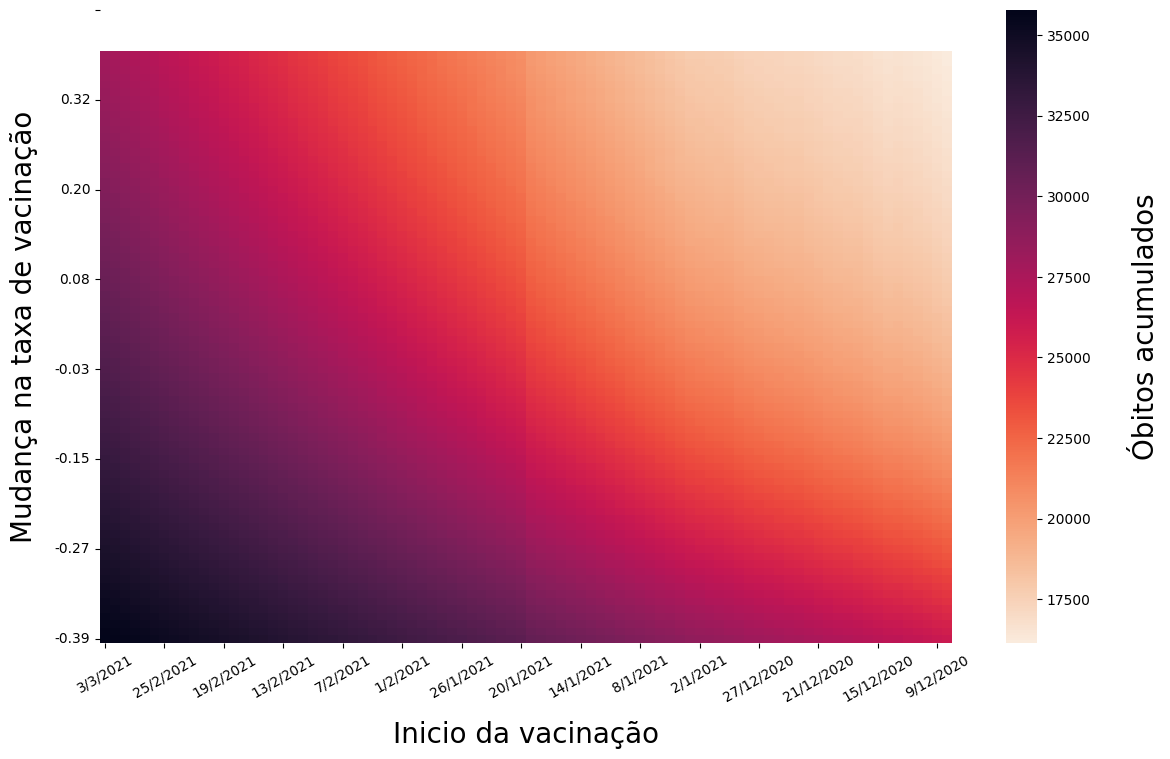

In [15]:
from datetime import datetime, timedelta


fatores_poucos = []

for item in lista_de_fator_multiplicacao:
    if item > 0:
        fatores_poucos.append(str(item)[:4])
    else: 
        fatores_poucos.append(str(item)[:5])

t = np.arange(datetime(2020,12,8), datetime(2021,3,4), timedelta(days=1)).astype(datetime)

list_de_tempos = []

for i in t:
    data_nova = str(i.day) + "/" + str(i.month) + "/" + str(i.year)
    list_de_tempos.append(data_nova)

fig, ax = plt.subplots(figsize=(12,8))
df = pd.DataFrame(data=matriz, columns=reversed(list_de_tempos), index=fatores_poucos)
s = sns.heatmap(df, cbar_kws={'label': 'Óbitos acumulados'}, square=False, cmap="rocket_r")
ax.figure.axes[-1].yaxis.label.set_size(20)
ax.figure.axes[-1].yaxis.labelpad = 30
ax.invert_yaxis()
s.set_xlabel('Inicio da vacinação', fontsize=20, labelpad=12)
s.set_ylabel('Mudança na taxa de vacinação', fontsize=20, labelpad=12)

plt.tight_layout()
ax.set_xticks(ax.get_xticks()[::3])
ax.set_yticks(ax.get_xticks()[::2])
plt.setp(ax.get_xticklabels(), rotation=30)
plt.show()

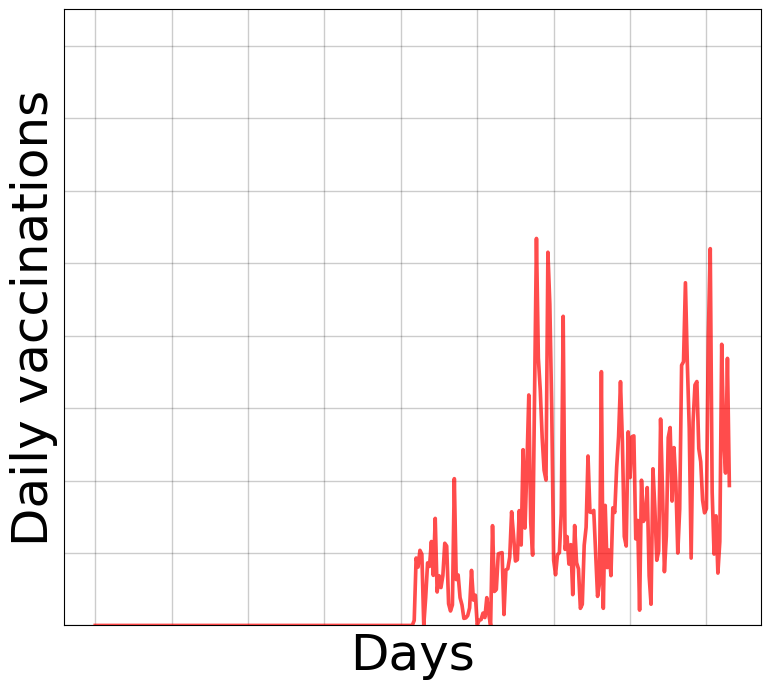

In [16]:
N = 14873064

#Criando plot
fig, ax = plt.subplots(figsize=(9,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.2)

# Taxa de casos - dados
taxa_casos_dados = novos_vacinados
ax.plot(taxa_casos_dados, color='red', zorder=3, lw=np.pi-0.5,alpha=0.7)

ax.autoscale()

#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
plt.setp(ax.get_xticklabels(), rotation=30)


#Setting the font of the numbers on the axixis as ARIAL 
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")  
ax.set_ylim(0, 170000)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

ax.set_xlabel("Days", size=36)
ax.set_ylabel("Daily vaccinations" , size=36)

#Show Graph       
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


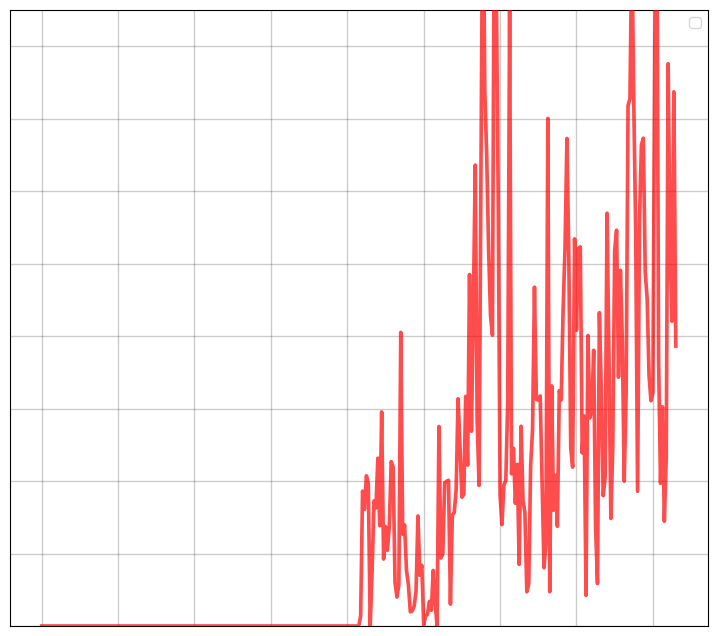

In [17]:
N = 14873064

#Criando plot
fig, ax = plt.subplots(figsize=(9,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.2)

# Taxa de casos - dados
taxa_casos_dados = np.array(novos_vacinados)+np.array(novos_vacinados)
ax.plot( taxa_casos_dados, color='red', zorder=3, lw=np.pi-0.5,alpha=0.7)

ax.autoscale()

#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
plt.setp(ax.get_xticklabels(), rotation=30)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

#Setting the font of the numbers on the axixis as ARIAL 
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")  
ax.set_ylim(0, 170000)

#Show Graph       
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


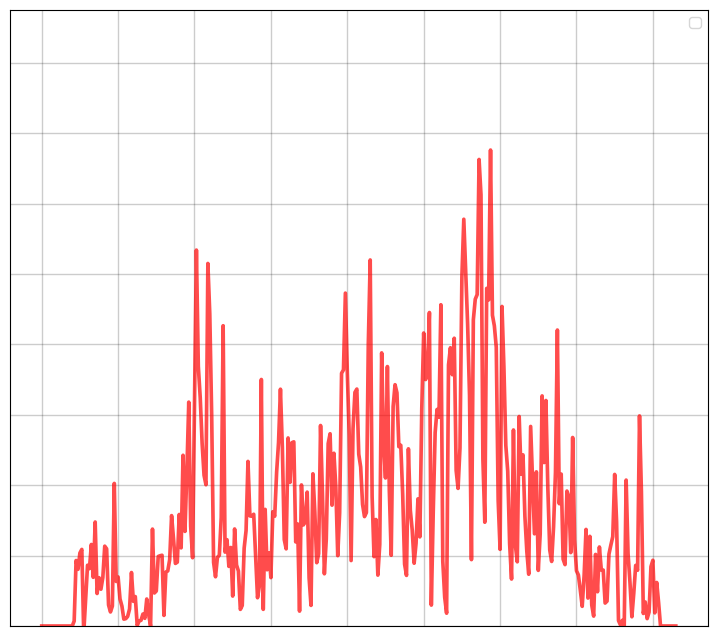

In [18]:
N = 14873064

#Criando plot
fig, ax = plt.subplots(figsize=(9,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.2)

# Taxa de casos - dados
taxa_casos_dados = np.diff(vacinados_dados)
ax.plot(datas[:len(taxa_casos_dados)], taxa_casos_dados, color='red', zorder=3, lw=np.pi-0.5,alpha=0.7)

ax.autoscale()

#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
plt.setp(ax.get_xticklabels(), rotation=30)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
#Setting the font of the numbers on the axixis as ARIAL 
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")  
ax.set_ylim(0, 175000)
#Show Graph       
plt.legend()
plt.show()


In [19]:
from itertools import combinations

# Define the lists
lists = [
    [1, 2, 3, 4, 7, 8, 10, 13, 15, 16, 18, 19, 21, 24, 25],
    [1, 3, 5, 6, 7, 9, 11, 12, 14, 16, 18, 20, 22, 23, 24],
    [2, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 19, 21, 23, 25],
    [1, 2, 3, 5, 7, 9, 10, 11, 13, 14, 15, 18, 20, 22, 24],
    [1, 2, 4, 6, 8, 9, 10, 12, 14, 16, 17, 19, 21, 23, 25],
    [1, 3, 5, 7, 11, 13, 18, 20, 22, 24, 8, 15, 19, 21, 25],
    [2, 4, 6, 8, 9, 10, 12, 14, 16, 17, 23, 21, 13, 19, 25],
    [1, 3, 5, 6, 7, 9, 11, 12, 14, 15, 18, 19, 20, 22, 24],
    [2, 4, 5, 7, 8, 9, 10, 12, 13, 14, 16, 18, 21, 23, 25],
    [1, 2, 3, 4, 6, 8, 10, 11, 12, 15, 17, 19, 22, 24, 25],
    [1, 3, 5, 7, 9, 11, 13, 14, 16, 17, 18, 20, 22, 23, 25],
    [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
    [2, 4, 6, 7, 8, 9, 10, 11, 13, 15, 17, 19, 21, 23, 25],
    [1, 2, 3, 4, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25],
    [1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 14, 18, 20, 22, 25]
]

# Function to check for duplicate sequences
def has_duplicates(seq):
    seen = set()
    for subseq in combinations(seq, 15):
        if subseq in seen:
            return True
        seen.add(subseq)
    return False

# Check for duplicates in each list
for i, lst in enumerate(lists):
    if has_duplicates(lst):
        print(f"Duplicate sequence found in List {i+1}")
